In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        X_DEC_IND =1
        val = self.func(last_output[X_DEC_IND], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

In [4]:
# config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.NoSideInformation: 3>

In [5]:
torch.__version__

'1.5.1'

In [6]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)
path = "../src/dsin/data"
valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["nano_KITTI_stereo_val.txt"])
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["nano_KITTI_stereo_train.txt"])

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

# ll = image_lists.label_from_func(lambda x: x)

batchsize = 1
data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist)])



In [7]:
learn.model.true_tuple_loss_false_just_out = True

for i in range(2):
    learn.fit(10)
    learn.save(f'stage-{(i+1)*10}')
    print(i)

epoch,train_loss,valid_loss,_calc_dist,time
0,1035.702026,1930.819336,0.012794,00:36


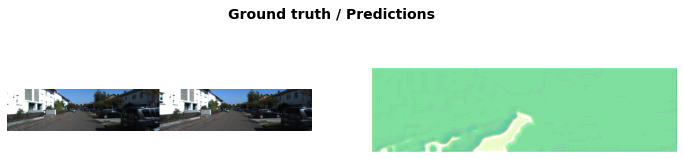

In [10]:
learn.model.true_tuple_loss_false_just_out = False
learn.show_results()

In [8]:
# # my_learner.fit_one_cycle(10)
# # my_learner.lr_find()
# # my_learner.save('stage-1')
# # my_learner.recorder.plot()
# # my_learner.load('stage-1')
# # my_learner.save("trained_model-stage1", return_path=True)
# # my_learner.export("trained_model_ex_stage1.pkl")